# Маркетинговый анализ приложения Procrastinate Pro+

**Цель проекта:**

Разобраться с причинами убытков маркетингового отдела приложения Procrastinate Pro+. 

**Предоставленные данные:**
- лог сервера с данными об их посещениях,
- выгрузка их покупок за этот период,
- рекламные расходы.

**Что необходимо сделать?**
1. Понять, откуда приходят пользователи, какими устройствами они пользуются, в каком регионе они находятся.
2. Сколько стоит привлечение пользователей из различных рекламных каналов, а также в разбивке по девайсу и региону.
3. Узнать, окупается ли реклама, направленная на привлечение пользователей в целом.
4. Понять, какие факторы мешают привлечению клиентов.

## Загрузка данных и подготовка к анализу

**Пути к файлам**

- визиты: [скачать датасет](https://code.s3.yandex.net/datasets/visits_info_short.csv);
- заказы: [скачать датасет](https://code.s3.yandex.net/datasets/orders_info_short.csv);
- расходы: [скачать датасет](https://code.s3.yandex.net/datasets/costs_info_short.csv).


In [40]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [41]:
visits = pd.read_csv('https://code.s3.yandex.net/datasets/visits_info_short.csv')
orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders_info_short.csv')
costs = pd.read_csv('https://code.s3.yandex.net/datasets/costs_info_short.csv')

**Проверим таблицу visits**

In [42]:
# переименуем названия столбцов
visits.columns = ['user_id', 'region', 'device', 'channel', 'session_start', 'session_end']
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        309901 non-null  int64 
 1   region         309901 non-null  object
 2   device         309901 non-null  object
 3   channel        309901 non-null  object
 4   session_start  309901 non-null  object
 5   session_end    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [43]:
# меняем тип данных в столбцах с датами сессии 
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

In [44]:
# проверка на дубликаты
visits.duplicated().sum()

0

In [45]:
# проверка на скрытые дубликаты
visits['region'].unique()
visits['device'].unique()
visits['channel'].unique()

array(['organic', 'TipTop', 'RocketSuperAds', 'YRabbit', 'FaceBoom',
       'MediaTornado', 'AdNonSense', 'LeapBob', 'WahooNetBanner',
       'OppleCreativeMedia', 'lambdaMediaAds'], dtype=object)

In [46]:
# проверка на пропуски
visits.isna().sum().sort_values()

user_id          0
region           0
device           0
channel          0
session_start    0
session_end      0
dtype: int64

**Проверим таблицу orders**

In [47]:
# переименуем названия столбцов
orders.columns = ['user_id', 'event_dt', 'revenue']
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   40212 non-null  int64  
 1   event_dt  40212 non-null  object 
 2   revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [48]:
# меняем тип данных в столбцах с датами 
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

In [49]:
# проверка на дубликаты
visits.duplicated().sum()

0

In [50]:
# проверка на пропуски
visits.isna().sum().sort_values()

user_id          0
region           0
device           0
channel          0
session_start    0
session_end      0
dtype: int64

**Проверим таблицу costs**

In [51]:
# переименуем названия столбцов
costs.columns = ['dt','channel','costs']
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [52]:
# меняем тип данных в столбцах с датами 
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

In [53]:
# проверка на дубликаты
costs.duplicated().sum()

0

In [54]:
# проверка на пропуски
costs.isna().sum().sort_values()

dt         0
channel    0
costs      0
dtype: int64

В таблицах отсутсвуют пропуски и дубликаты. 

Анализ пользователей будет проводиться по:
- 4 странам - США, Великобритания, Франция и Германия, 
- 4 устройствам - iPhone, Mac, Android, PC,
- и 10 каналам продвижения, не включая органический рост - TipTop, RocketSuperAds, YRabbit, FaceBoom, MediaTornado, AdNonSense, LeapBob, WahooNetBanner, OppleCreativeMedia, lambdaMediaAds,
- с 2 категориями пользователей: платящие и не платящие.

## Функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Это функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

**Создаем профили пользователей - функция get_profiles()**

In [55]:
def get_profiles(visits, orders, ad_costs):
    
    profiles = (
        visits.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg({'session_start': 'first', 'channel': 'first', 'device': 'first', 'region': 'first'})
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )
    
    profiles['dt'] = pd.to_datetime(profiles['first_ts']).dt.date
    
    profiles['payer'] =  profiles['user_id'].isin(orders['user_id'].unique()) #добавляем информацию о покупке из orders    

    # считаем количество уникальных пользователей с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
         # столбец с числом пользователей назовём unique_users
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()  # возвращаем dt и channel из индексов
    )

    # объединяем траты на рекламу и число привлечённых пользователей по дате и каналу привлечения
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    # результаты сохраним в столбец acquisition_cost (CAC)
    ad_costs['acquisition_cost'] = round(ad_costs['costs'] / ad_costs['unique_users'],2)

    # добавим стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # органические пользователи не связаны с данными о рекламе,
    # поэтому в столбце acquisition_cost у них значения NaN
    # заменим их на ноль, ведь стоимость привлечения равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

profiles = get_profiles(visits, orders, costs)
profiles.head()

,user_id,first_ts,channel,device,region,dt,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,True,1.09
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,False,1.11
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,False,0.00
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,False,0.99
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,False,0.23


**Функция для подсчета Retention rate**

In [56]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

**Функция для подсчёта конверсии**

In [57]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']
# функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis=1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time


**Функция для расчета LTV**

In [58]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # сохраняем в датафрейм данные пользователей и значения CAC, 
        # добавив параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

In [59]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, datetime(2019, 11, 1).date(), 14, dimensions=['channel']
)

**Функция для сглаживания данных**

In [60]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

**Функция для построения графика Retention Rate**

In [61]:
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в четвёртой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()
         

**Функция для построения графика конверсии**

In [62]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

**Функция для визуализации LTV и ROI**

In [63]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True,ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [64]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # --- 1 график — кривые ltv ---
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # --- 2 график — динамика ltv ---
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # --- 3 график — динамика cac ---
    ax3 = plt.subplot(2, 3, 3)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # --- 4 график — кривые roi ---
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True,ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # --- 5 график — динамика roi ---
    ax5 = plt.subplot(2, 3, 5)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__
    
Хорошо, все необходимые функции были заданы, можно приступать к расчета и анализу👀

## Исследовательский анализ данных (EDA)

In [65]:
profiles_with_organic = get_profiles(visits, orders, costs)
profiles_with_organic.head()

,user_id,first_ts,channel,device,region,dt,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,True,1.09
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,False,1.11
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,False,0.00
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,False,0.99
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,False,0.23


Определим минимальную и максимальную даты привлечения пользователей:

In [66]:
# минимальная дата привлечения пользователей
display(profiles['dt'].min()) 

# максимальная дата привлечения 
profiles['dt'].max()

datetime.date(2019, 5, 1)

datetime.date(2019, 10, 27)

Минимальная дата привлечения пользователей - 1 мая 2019 г. 

Максимальная дата привлечения пользователей - 27 октября 2019 г.

Выясним распределение долей платящих пользователей по странам:

In [67]:
users_by_region = (
    profiles.groupby('region')
    .agg({'user_id' : 'count', 'payer' : 'sum'})
    .sort_values(by='user_id', ascending=False).reset_index())    

users_by_region['share'] = round(users_by_region['payer'] / users_by_region['user_id']  * 100 ,2)

users_by_region

,region,user_id,payer,share
0,United States,100002,6902,6.90
1,UK,17575,700,3.98
2,France,17450,663,3.80
3,Germany,14981,616,4.11


На США приходится наибольшее количество пользователей, а также наибольшее количество платящих пользователей в натуральном выражении. Доля платных пользователей по странам следующая: Почти 10% - США, Великобритания - 5%, Франция - 5%, Германия 5%.

Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи:

In [68]:
users_by_device = (
    profiles.groupby('device')
    .agg({'user_id' : 'count',
         'payer' : 'sum'})
    .sort_values(by='payer', ascending=False)
)    


# доля платящих пользователей в разбивке по девайсам
users_by_device['share_of_paying_users'] = round(users_by_device['payer'] * 100 / users_by_device['payer'].sum(),2)
# доля пользователей n-го девайса, которые являются платящими (по отношению ко всем пользователям n-го девайса)
users_by_device['%_of_paying_users_by_device'] = round(users_by_device['payer'] / users_by_device['user_id'] * 100,2)

users_by_device

,user_id,payer,share_of_paying_users,%_of_paying_users_by_device
device,,,,
iPhone,54479,3382,38.08,6.21
Android,35032,2050,23.08,5.85
Mac,30042,1912,21.53,6.36
PC,30455,1537,17.31,5.05


Мы видим, что в разбивке по девайсам пользователи "конвертируются" в платящих пользователей примерно с одинаковой долей (Iphone - 8.8%, Android - 8.2%, Mac - 9%), кроме ПК (6.8%).

Определим каналы, из которых пришло больше всего платящих пользователей:

In [69]:
users_by_channel = (
    profiles.groupby('channel')
    .agg({'user_id' : 'count',
         'payer' : 'sum'})
    .sort_values(by='payer', ascending=False)
)

# доля платящих пользователей в разбивке по девайсам
users_by_channel['share_of_paying_users'] = users_by_channel['payer'] / users_by_channel['user_id'] * 100

users_by_channel = (users_by_channel.sort_values(by='share_of_paying_users', ascending=False).style
.format("{:.2f}", subset=['share_of_paying_users'])
.background_gradient(axis=0, cmap='Blues'))

In [70]:
users_by_channel

,user_id,payer,share_of_paying_users
channel,,,
FaceBoom,29144,3557,12.20
AdNonSense,3880,440,11.34
lambdaMediaAds,2149,225,10.47
TipTop,19561,1878,9.60
RocketSuperAds,4448,352,7.91
WahooNetBanner,8553,453,5.30
YRabbit,4312,165,3.83
MediaTornado,4364,156,3.57
LeapBob,8553,262,3.06


У каналов FaceBoom, AdNonSense и lambdaMediaAds, TipTop, RocketSuperAds наибольшии доли платящих пользователей (12.2%, 11.3%, 10.5%, 9.6% и 7.9% соответсвенно).

**Вывод:**
    
Региональная особенность: на США приходится наибольшее количество пользователей, а также наибольшее количество платящих пользователей в натуральном выражении. Доля платных пользователей по странам следующая: Почти 10% - США, Великобритания - 5%, Франция - 5%, Германия 5%.

Разбивка по девайсам: мы видим, что в разбивке по девайсам пользователи "конвертируются" в платящих пользователей примерно с одинаковой долей (Iphone - 8.8%, Android - 8.2%, Mac - 9%), кроме ПК (6.8%).

Разбивка по каналам привлечения: у каналов FaceBoom, AdNonSense и lambdaMediaAds, TipTop, RocketSuperAds наибольшии доли платящих пользователей (12.2%, 11.3%, 10.5%, 9.6% и 7.9% соответсвенно).

## Маркетинг

- Посчитаем общую сумму расходов на маркетинг.
- Выясним, как траты распределены по рекламным источникам.
- Посмотрим на динамику изменения расходов во времени.
- Узнаем, сколько в среднем стоило привлечение одного пользователя из каждого источника.

In [71]:
# общая сумма расходов на маркетинг
total_cost = costs['costs'].sum().round()
print('Сумма расходов на маркетинг составляет', total_cost)

Сумма расходов на маркетинг составляет 105497.0


In [72]:
# распределение трат по рекламным источникам
costs_by_channel = (
    costs.groupby('channel')
    .agg({'costs': 'sum'})
    .sort_values(by='costs', ascending=False)
)    
costs_by_channel['share'] = round(costs_by_channel['costs']/costs_by_channel['costs'].sum() * 100 ,2)
costs_by_channel

,costs,share
channel,,
TipTop,54751.30,51.90
FaceBoom,32445.60,30.75
WahooNetBanner,5151.00,4.88
AdNonSense,3911.25,3.71
OppleCreativeMedia,2151.25,2.04
RocketSuperAds,1833.00,1.74
LeapBob,1797.60,1.70
lambdaMediaAds,1557.60,1.48
MediaTornado,954.48,0.90


Половина маркетингового бюджета приходится на TipTop, 
30% бюджета - на FaceBoom, на остальные 8 источников приходится по отдельности от 1 до 5%.

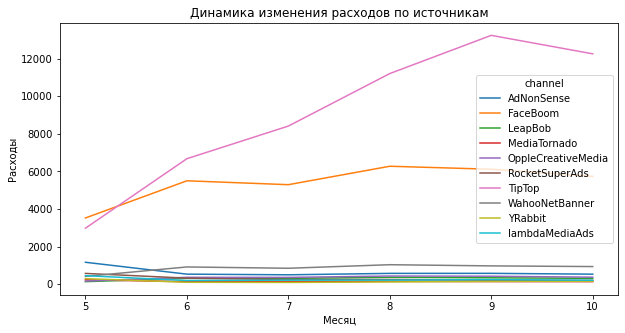

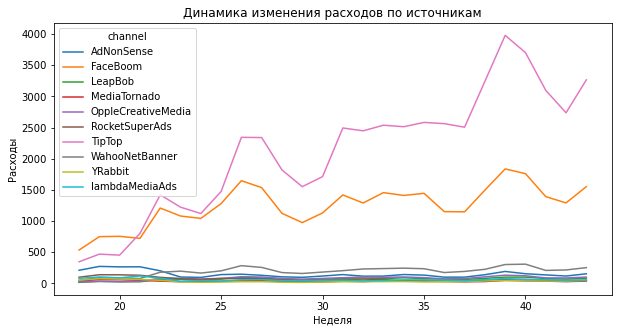

In [73]:
# добавляем столбцы месеяца и недели
costs['month'] = pd.to_datetime(costs['dt']).dt.month
costs['week'] = pd.to_datetime(costs['dt']).dt.isocalendar().week

# строим таблицы для графиков
costs_by_month = costs.pivot_table(index='month', columns='channel', values='costs', aggfunc='sum')
costs_by_week = costs.pivot_table(index='week', columns='channel', values='costs', aggfunc='sum')

costs_by_month.plot(figsize =(10,5))
plt.title('Динамика изменения расходов по источникам')
plt.xlabel('Месяц')
plt.ylabel('Расходы')
plt.show()

costs_by_week.plot(figsize =(10,5))
plt.title('Динамика изменения расходов по источникам')
plt.xlabel('Неделя')
plt.ylabel('Расходы')
plt.show()

Видим, что два на графике выделяются два наиболее затратных источника: Tip Top и FaceBoom.

Узнаем, сколько в среднем стоило привлечение одного пользователя из каждого источника:

In [74]:
avg_cost_per_user = (
    profiles.groupby('channel').agg ({'acquisition_cost': 'mean'})
    .sort_values('acquisition_cost', ascending = False).round(2).reset_index()
)
avg_cost_per_user

,channel,acquisition_cost
0,TipTop,2.80
1,FaceBoom,1.11
2,AdNonSense,1.01
3,lambdaMediaAds,0.72
4,WahooNetBanner,0.60
5,RocketSuperAds,0.41
6,OppleCreativeMedia,0.25
7,MediaTornado,0.22
8,YRabbit,0.22
9,LeapBob,0.21


Посчитаем средний CAC по проекту:

In [39]:
round(profiles['acquisition_cost'].mean(),2)

0.7

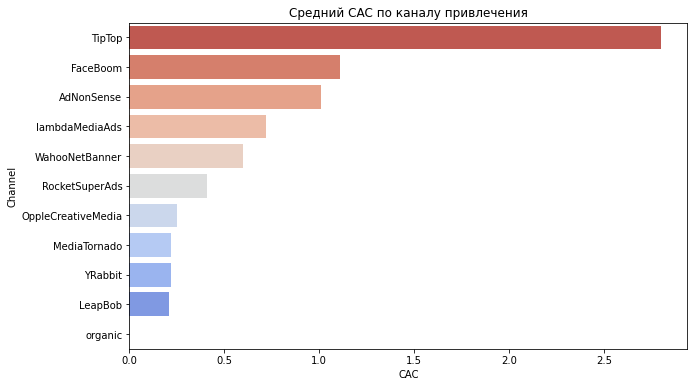

In [75]:
plt.figure(figsize=(10, 6))
sns.barplot(data=avg_cost_per_user, x='acquisition_cost', y='channel', palette='coolwarm_r')

plt.title('Средний CAC по каналу привлечения')
plt.xlabel('CAC')
plt.ylabel('Channel')

plt.show()

Стоимость привлечения одного пользователя (CAC) сильно выше в Tip Top - 2,8. Далее идут FaceBoom - 1,1, AdNonSense - 1,0 и lambdaMediaAds - 0,7.

**Вывод:**

Половина маркетингового бюджета приходится на TipTop, 30% бюджета - на FaceBoom, на остальные 8 источников приходится по отдельности от 1 до 5%, стоимость привлечения одного пользователя в среднем выше в Tip Top, FaceBoom и AdNonSense. Делаем вывод, что наиболее затратными источниками привлечения пользователей являются каналы Tip Top и FaceBoom. 

## Оценим окупаемость рекламы

Поправка: считаем, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения.

Ответим на главные вопросы:
- Окупается ли реклама, направленная на привлечение пользователей в целом?
- Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
- Чем могут быть вызваны проблемы окупаемости?

**Комментарий:** Так как в этом пункте мы оцениваем окупаемость рекламы, я бы убрала из анализа органических пользователей. Таблица profiles сейчас не включает пользователей из канала organic.

In [76]:
profiles = profiles.query('channel != "organic"')
profiles

,user_id,first_ts,channel,device,region,dt,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,True,1.09
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,False,1.11
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,False,0.99
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,False,0.23
7,46006712,2019-06-30 03:46:29,AdNonSense,Android,France,2019-06-30,True,1.01
...,...,...,...,...,...,...,...,...
149999,999942424543,2019-05-24 21:03:26,TipTop,iPhone,United States,2019-05-24,False,1.90
150001,999949280903,2019-08-12 06:47:27,FaceBoom,Mac,United States,2019-08-12,False,1.12
150003,999956196527,2019-09-28 08:33:02,TipTop,iPhone,United States,2019-09-28,False,3.50
150005,999976332130,2019-07-23 02:57:06,TipTop,iPhone,United States,2019-07-23,False,2.60


### Проанализируем окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.

In [77]:
observation_date = datetime(2019, 11, 1).date() # момент анализа
horizon_days = 14 # горизонт анализа 

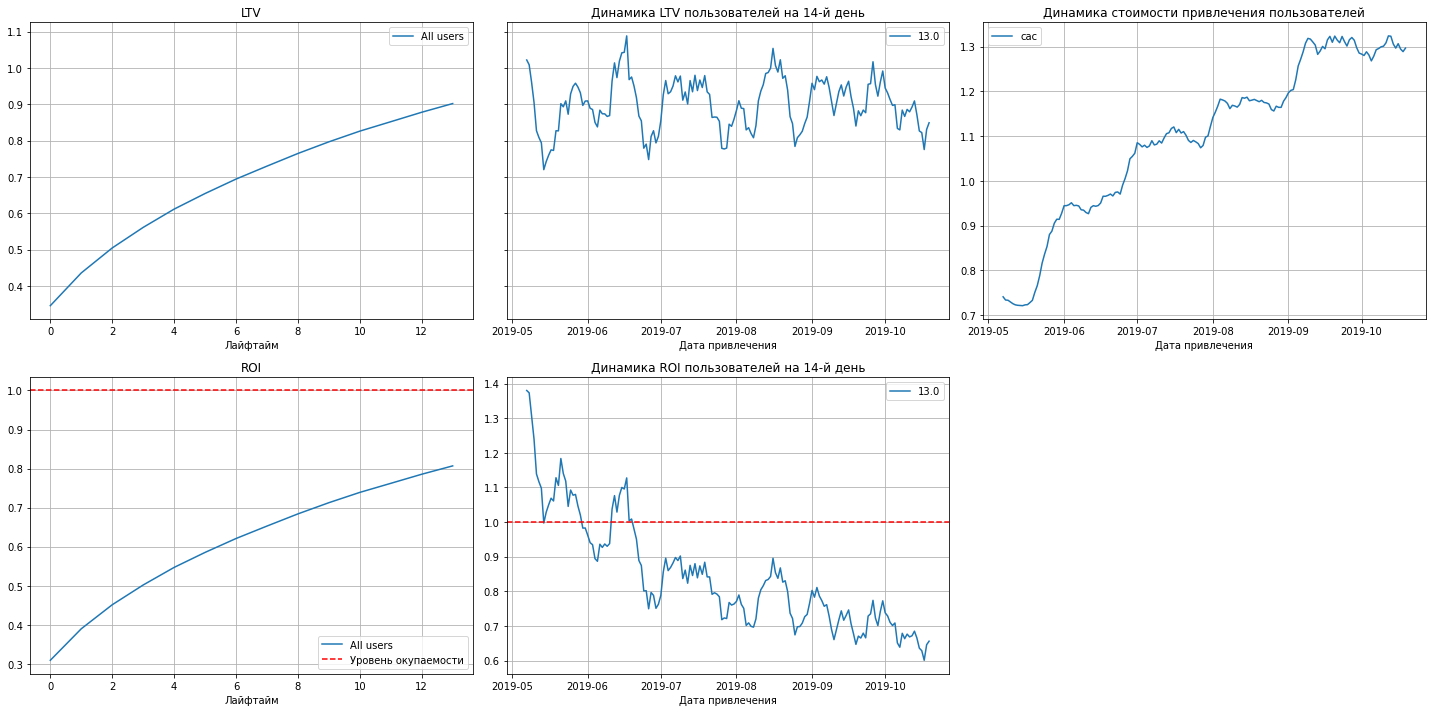

In [78]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days) 

На 4 графике мы видим, что реклама не окупается за 2 недели. 
Наблюдаем, что динамика ROI за лайфтайм падает. ROI в динамике показывает, что реклама не окупается с середины июня. При относительно стабильной динамике LTV, динамика САС растёт с мая по конец октября. Эту закономерность мы наблюдаем в динамике ROI, что при сильном увеличении САС, в равной степени падает динамика ROI пользователей.

### Проверим конверсию пользователей и динамику её изменения. То же самое сделаем с удержанием пользователей. 

**1) в разбивке по каналам**

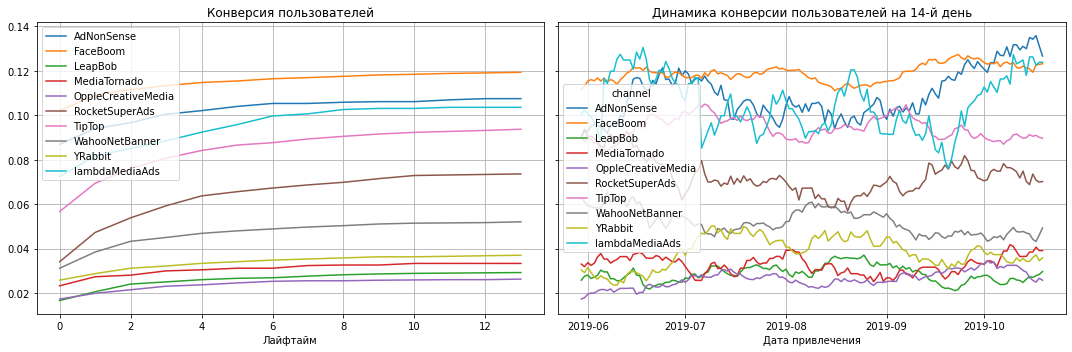

In [79]:
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions = ['channel']
)
plot_conversion(conversion, conversion_history, horizon_days, 30) 

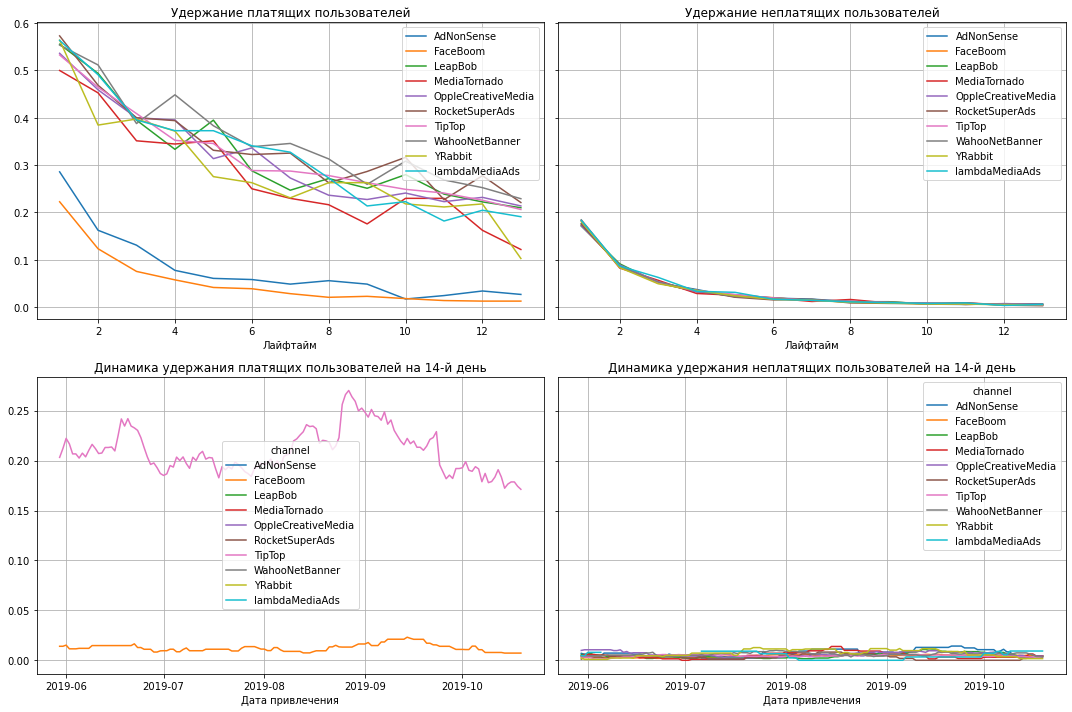

In [80]:
retention_raw, retention, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions = ['channel']
)

plot_retention(retention, retention_history, horizon_days, 30)  

Топ-3 каналов по конверсии - FaceBoom, AdNonSense, lambdaMediaAd.
Худшие каналы по удержанию - FaceBoom и AdNonSense, значительно отличаются своими результатами от других каналов привлечения.

**2) в разбивке по девайсам**

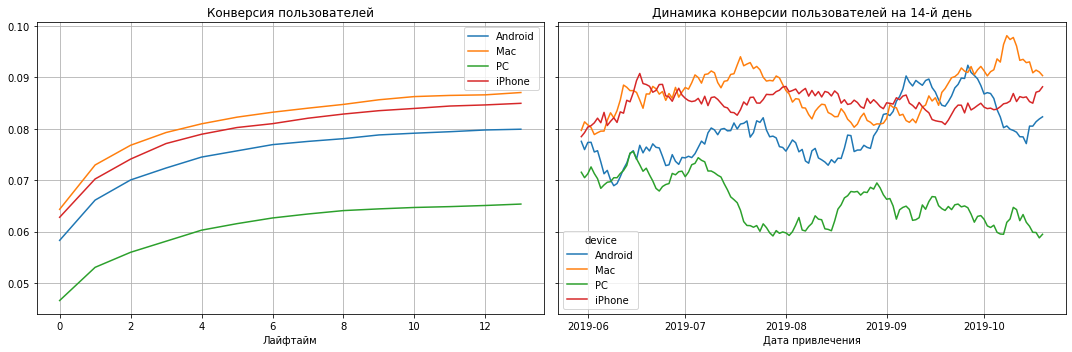

In [81]:
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions = ['device']
)
plot_conversion(conversion, conversion_history, horizon_days, 30) 

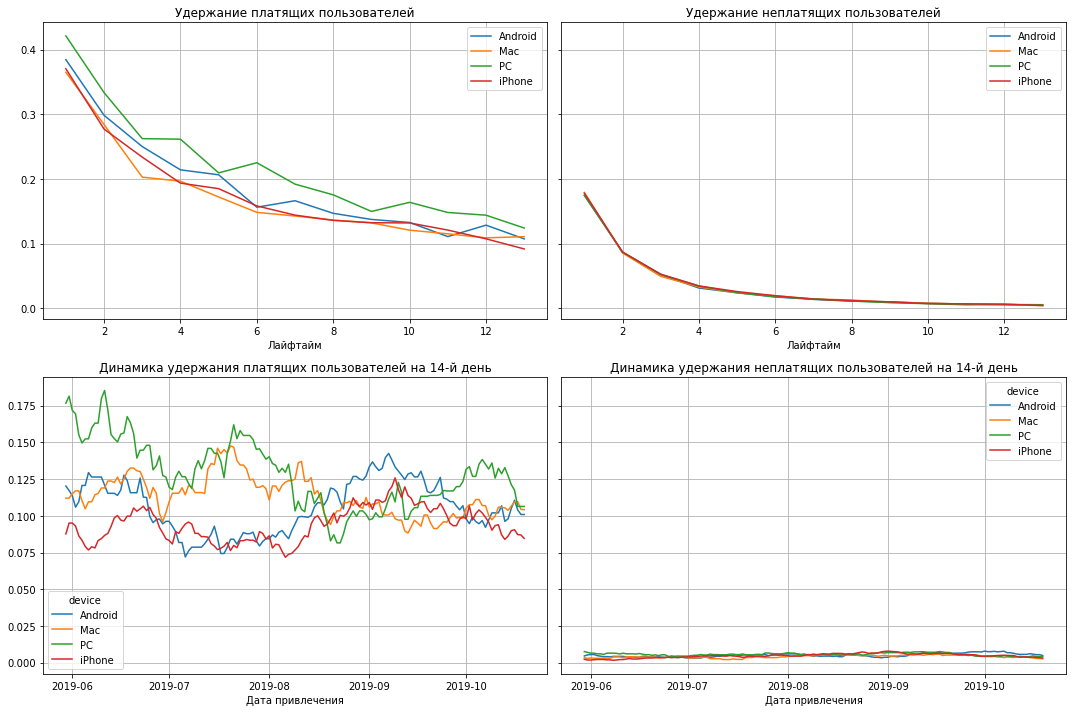

In [82]:
retention_raw, retention, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions = ['device']
)

plot_retention(retention, retention_history, horizon_days, 30) 

Мы видим, что самая худшая конверсия у PC, самая лучшая у продукции apple, при этом удержение у всех девайсов практически одинаковое (у ПК немного выше). 

**3) в разбивке по странам**

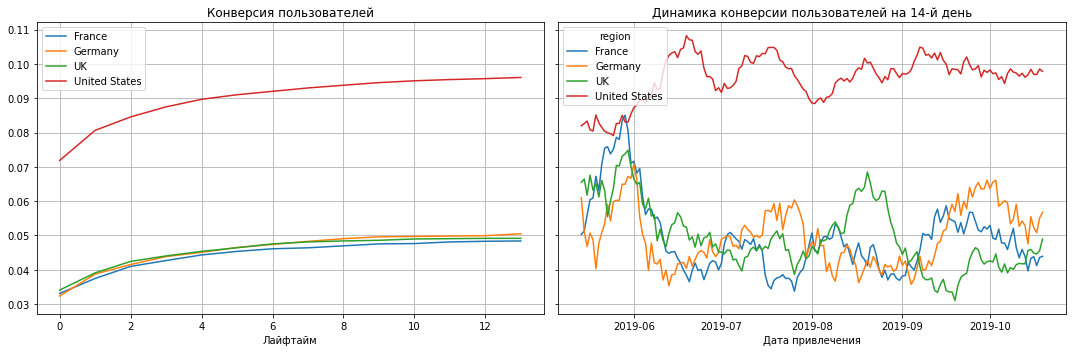

In [83]:
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions = ['region']
)
plot_conversion(conversion, conversion_history, horizon_days, 14) 

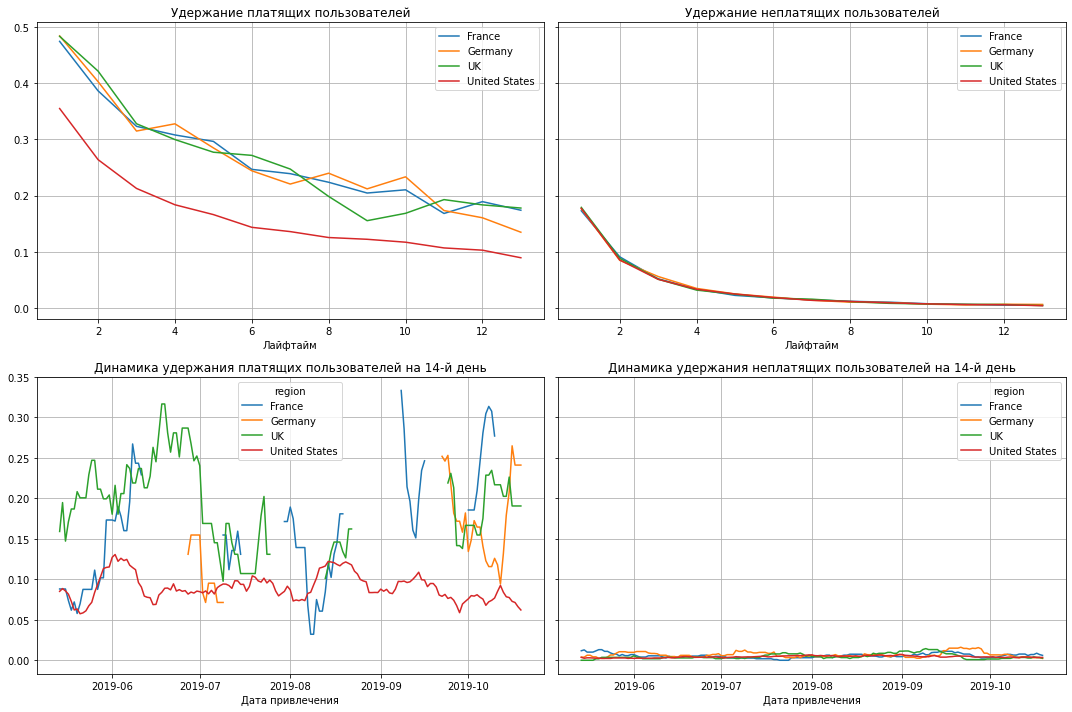

In [84]:
retention_raw, retention, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions = ['region']
)

plot_retention(retention, retention_history, horizon_days, 14)

Конверсия платящих пользователей в США практически в 2 раза выше, чем у других стран, то же самое и с конверсией в динамике.
Удержание платящих пользователей в США ниже, чем в остальных регионах, у неплатящих разницы нет. 

### Проанализируем окупаемость рекламы с разбивкой по устройствам.

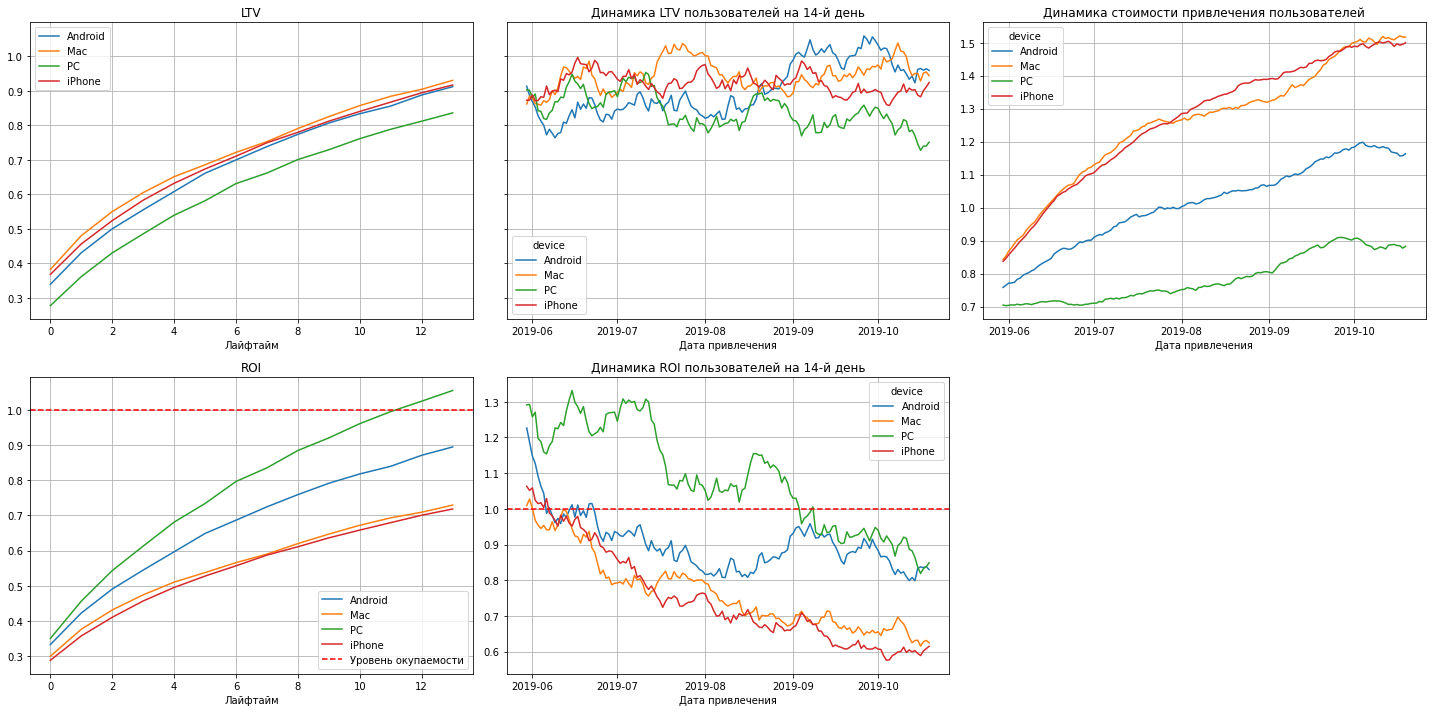

In [85]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['device']
)
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=30) 

LTV у PC намного ниже, чем у других девайсов, при этом, ROI через PC окупается за горизонт анализа в 2 недели. С окупаемостью проблемы по всем устройствам кроме PC. Это значит, что у нас, по крайней мере, нет технических проблем, влияющих на монетизацию.

Рост стоимости привлечения клиентов происходит за счет девайсов apple, ROI в динамике падает у всех девайсов.

### Проанализируем окупаемость рекламы с разбивкой по странам.

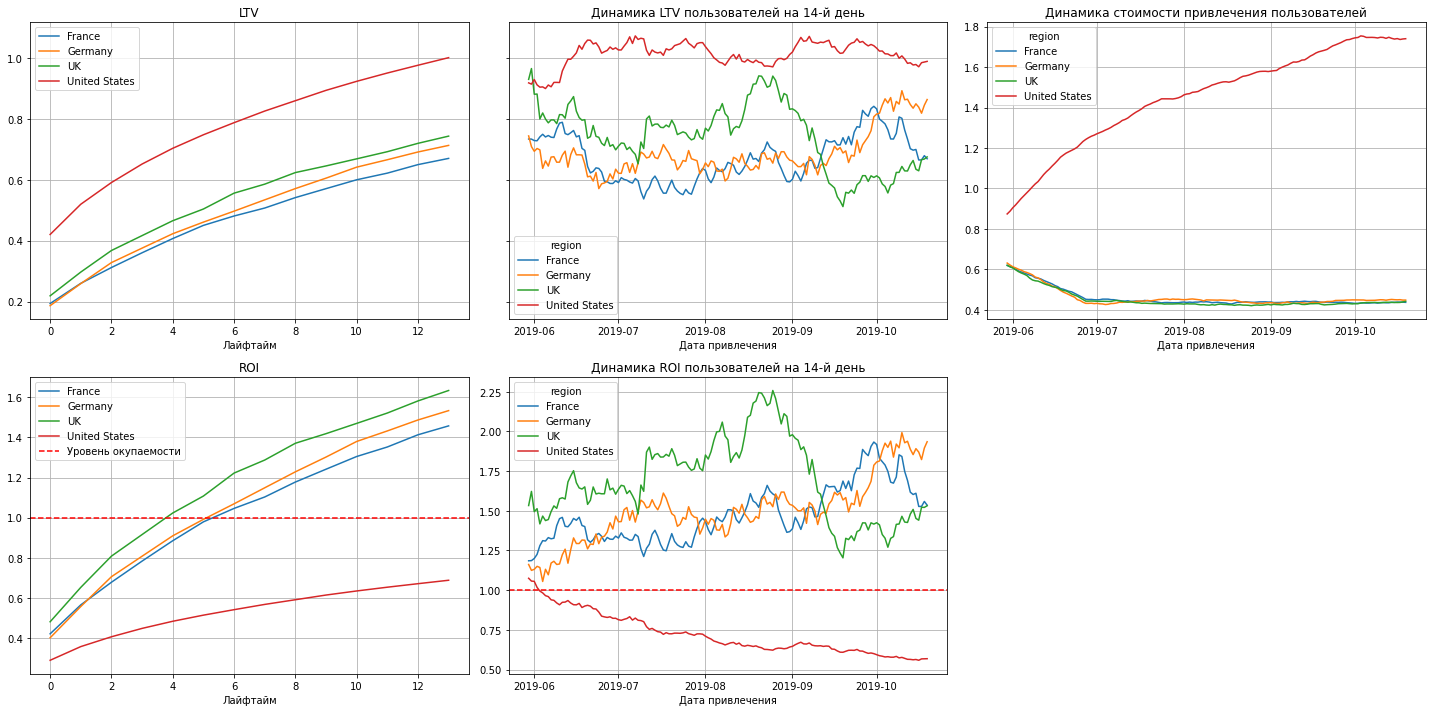

In [86]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['region']
)
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=30) 

Мы видим, что данные по США значительно отличаются от других регионов.

LTV у пользователей США выше, чем в других странах, при этом стоимость привлечения пользователей несоразмерно велика, тем самым ROI составляет меньше 1 (не окупается), с динамикой тоже беда. 

Нужно разбираться детальнее с рекламой в США, тем более, что это наш основной рынок.

### Проанализируем окупаемость рекламы с разбивкой по рекламным каналам.

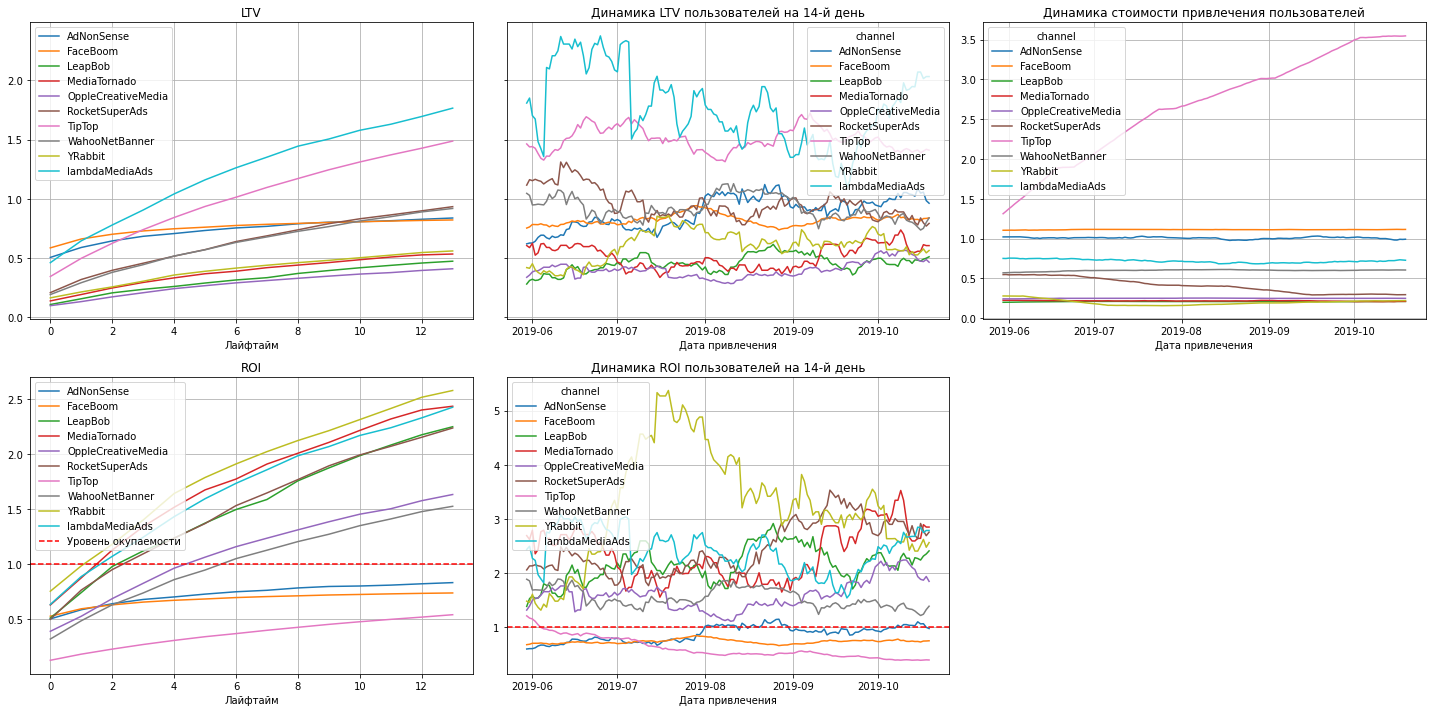

In [87]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['channel']
)
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=30) 

LTV заметно выдлеятся у lambdaMediaAds и Tiptop (выше 1), также и динамика. 
Мы нашли 3 канала, которые не окупаются: FaceBoom, AdNonSense и Tiptop (они же каналы с самой высокой стоимостью привлечения).

**Вывод.** 
Мы видим, что реклама не окупается за 2 недели. ROI в динамике показывает, что реклама не окупается с середины июня. Стоимость привлечения пользователей постоянно растет.

    
**Посмотрим на конверсию и удержание в разбивке по источникам привлечения:** мы нашли топ-3 канала по конверсии - FaceBoom, AdNonSense, lambdaMediaAd. Худшие каналы по удержанию - FaceBoom и AdNonSense, значительно отличаются своими результатами от других каналов привлечения. *Таким образом, мы видим, что каналы FaceBoom, AdNonSense способны привлечь больше пользователей, но не способны их удержать.*
    
**Конверсия и удержание в разбивке по девайсам.** Самая худшая конверсия у PC, самая лучшая у продукции apple, при этом удержение у всех девайсов практически одинаковое.
    
**Конверсия и удержание в разбивке по странам.** Конверсия платящих пользователей в США практически в 2 раза выше, чем у других стран, то же самое и с конверсией в динамике. Удержание платящих пользователей в США ниже, чем в остальных регионах, у неплатящих разницы нет.   
    
**Окупаемость рекламы с разбивкой по устройствам.** LTV у PC намного ниже, чем у других девайсов, при этом, ROI через PC окупается за горизонт анализа в 2 недели. Рост стоиости привлечения клиентов происходит за счет девайсов apple  - самый высокий CAC у Iphone и Mac, ROI меньше единицы только у Iphone и Mac. ROI в динамике падает у всех девайсов.

**Окупаемость рекламы с разбивкой по странам.** LTV у пользователей США выше, чем в других странах, при этом стоимость привлечения пользователей несоразмерно велика. Поэтому коэфф ROI у США составляет меньше 1 (не окупается) и в динамике постоянно падает. У остальных стран ROI выше единицы.

**Окупаемость рекламы с разбивкой по рекламным каналам.** LTV заметно выдлеятся у lambdaMediaAds и Tiptop (то же и в динамике). Выделены 3 канала, которые не окупаются: FaceBoom, AdNonSense и Tiptop (они же каналы с самой высокой стоимостью привлечения). 


### Вывод

- Выделите причины неэффективности привлечения пользователей.
- Сформулируйте рекомендации для отдела маркетинга.

В целом, мы видим, что за горизонт анализа в 2 недели затраты на рекламу не окупаются. Мы видим проблему в целом регионе - США, где затраты на привлечение пользователей несоразмерно высоки, также наблюдается сильный рост стоимости привлечения клиентов у продукции apple. Несмотря на хорошую конверсию платящих юзеров США, в данном регионе самый низкий Retention rate, что тоже является проблемой.

Что касается каналов привлечения, мы обнаружили 3 канала, которые не окупаются: FaceBoom, AdNonSense и Tiptop (они же каналы с самой высокой стоимостью привлечения), а также двое из них: FaceBoom и AdNonSense являются худшими каналами по удержанию платящих пользователей. 
Хорошие показатели конверсии, удержания и ROI у канала lambdaMediaAds (а также доля платящих клиентов довольна высокая см. пункт 3  "Исследовательский анализ данных" - 10.5%), RocketSuperAds (с долей/"конверсией" в платящих пользоотелей 8%), WahooNetBanner и 
 Yrabbit (довольно хорошие показатели, низкая стоиомость привлечения).
 
*Отделу маркетинга Procrastinate Pro+ рекомендуется сократить финансирование через неокупающиеся каналы, в первую очередь через канал Tiptop, а также обратить внимание на каналы lambdaMediaAds, RocketSuperAds, WahooNetBanner.*

*Высокими затратами на привлечение пользователей также являются CAC в США. Возможно стоит выработать статегию привлечения платных пользователей с других регионов, где стоимость привлечения клиента не так высока.

Также мы видим, что CAC у Mac и Iphone примерно одинаковый, но доли платящих пользователей у Iphone - 38%, у Mac - 22%, можно немного сократить и расходы на привлечение пользователей Mac.